# NYRB Classics covers analysis

#### by [Aida Ylanan](https://twitter.com/a1daylanan) and [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

An analysis of the colors and content of book covers conducted for the Dec. 27, 2018, Los Angeles Times story "[Cover to cover: The colors of NYRB Classics](http://www.latimes.com/projects/la-et-jc-nyrb-covers/)."

### Import Python tools

In [1]:
import os
import re
import csv
import time
import requests
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from IPython.core.display import Image, display

### Collect cover images

The NYRB publishes most of its covers on [its website](https://www.nyrb.com/collections/classics). First, we scraped down its data. A few books were missing and were collected manually from other sources.

This first step downloads all the HTML we need to parse. Our research found that there are nine pages on the NYRB site that need to be crawled.

In [2]:
page_list = range(1, 10)

In [3]:
def download_page(page):
    """
    Download data from the NYRB website for parsing.
    """
    # Prepare the path for writing out the result.
    path = "./data/scraped-page-{}.html".format(page)
    
    # If the path already exists, the scrape is done and we can skip it.
    if os.path.exists(path):
        return
    
    # If it doesn't exist, let's go get it.
    print("Page {} being scraped".format(page))
    url = 'https://www.nyrb.com/collections/classics'
    headers = {'user-agent': 'Los Angeles Times Data Desk scraper (datadesk@latimes.com)'}
    params = {"page": page}
    r = requests.get(url, params=params, headers=headers)

    # Then write it out.
    with open(path, 'w') as f:
        f.write(r.text)
      
    # Finally, let's be nice and give NYRB's site a rest.
    time.sleep(2)

In [4]:
for page in page_list:
    download_page(page)

The data we need is now parsed from the HTML.

In [5]:
def parse_page(page):
    """
    Parse HTML scraped from the NYRB website.
    """
    # Prepare the path to be read in.
    path = "./data/scraped-page-{}.html".format(page)
    
    # Read in the HTML
    with open(path, 'r') as f:
        html = f.read()
    
    # Have BeautifulSoup parse it.
    soup = BeautifulSoup(html, "html5lib")
    
    # Pull out and save the divs we want to focus in on.
    div_list = [div for div in soup.find_all("div", class_="product")]
    
    # Loop through those divs and parse book metadata from those divs.
    book_list = []
    for div in div_list:
        book_dict = dict(
            detail_url='https://www.nyrb.com' + div.find("a")['href'],
            slug=div.find("a")['href'].split("/")[-1],
            cover_url="https://{}".format(div.find("img")['src'][2:]),
        )
        book_list.append(book_dict)
    
    # Return the parsed data
    return book_list

In [6]:
book_list = []
for page in page_list:
    book_list.extend(parse_page(page))

Download each book's cover image.

In [7]:
def download_cover(book):
    """
    Download an NYRB book's cover image.
    """
    # Prepare the path for this cover image
    path = os.path.join("data/raw-covers", book['slug'] + ".jpg")
    
    # If it already exists, skip it.
    if os.path.exists(path):
        return
    
    # If not, download it.
    urllib.request.urlretrieve(book['cover_url'], path)
    
    # Again, let's be nice.
    time.sleep(0.5)

In [8]:
for book in book_list:
    download_cover(book)

Scrape the detail page for each slug to fetch its ISBN

In [9]:
def download_book(book):
    """
    Download the detail page for each book.
    """
    # Prepare the path
    path = "./data/scraped-book-{}.html".format(book['slug'])
    
    # If it already exists, skip it.
    if os.path.exists(path):
        return
    
    # Otherwise, grab the page.
    headers = {'user-agent': 'Los Angeles Times Data Desk scraper (datadesk@latimes.com)'}
    r = requests.get(book['detail_url'], headers=headers)
    
    # And save it.
    with open(path, 'w') as f:
        f.write(r.text)
        
    # Be nice
    time.sleep(0.5)

In [10]:
for book in book_list:
    download_book(book)

Parse out the extra data we need from the detail page.

In [11]:
def parse_book(book):
    """
    Parse extra metadata the provided book from its detail page.
    """
    # Prepare the path to be read in.
    path = "./data/scraped-book-{}.html".format(book['slug'])
    
    # Read in the HTML
    with open(path, 'r') as f:
        html = f.read()
    
    # Have BeautifulSoup parse it.
    soup = BeautifulSoup(html, "html5lib")
    
    # Create a data dict with the parsed data.
    data_dict = dict()
    
    # Parse out the isbn
    data_dict['isbn'] = soup.find_all(
        "div",
        class_='description additional'
    )[0].find(class_='variant-sku').text
    
    # Parse the language string
    byline = soup.find_all("div", class_='span8')[0].find("h2", class_="combined-authors").text.strip()
    try:
        phrase = re.search('translated from the [a-zA-z]{1,10}', byline).group(0)
        language = re.split("\s+", phrase)[-1]
    except AttributeError:
        try:
            language = re.search('translated', byline).group(0)
        except AttributeError:
            language = 'English'
    
    data_dict['original_language'] = language
    
    # Parse the big image, if it exists
    img = soup.find("div", class_='image').find("img")
    if img:
        data_dict['large_cover'] = "http:" + img.parent['href']
    else:
        data_dict['large_cover'] = ''
     
    # Return the parsed data.
    return data_dict

In [12]:
for book in book_list:
    # Update the book dict with the newly parsed data.
    book.update(parse_book(book))

Download the large covers

In [13]:
def download_large_cover(book):
    """
    Download an NYRB book's large cover image.
    """
    # Prepare the path for this cover image
    path = os.path.join("data/large-covers", book['slug'] + "-large.jpg")
    
    # If it already exists, skip it.
    if os.path.exists(path):
        return
    
    # If not, download it.
    try:
        urllib.request.urlretrieve(book['large_cover'], path)
    except:
        pass
    # Again, let's be nice.
    time.sleep(0.5)

In [14]:
for book in book_list:
    download_large_cover(book)

Convert the whole thing into a DataFrame and write it out.

In [15]:
scraped_df = pd.DataFrame(book_list)

In [16]:
scraped_df.to_csv("data/scraped.csv", index=False)

### Merge covers with official list and other sources

NYRB provided an official list of Classics with publication date, title and author. Let's read that in.

In [17]:
nyrb_df = pd.read_csv("./data/nyrb.csv", dtype={"isbn": str})

It should have 500 rows.

In [18]:
assert len(nyrb_df) == 500

Join our scraped data via the isbn code.

In [19]:
merged_df = nyrb_df.merge(scraped_df, on="isbn", how="left")

After the join we should still have 500 rows.

In [20]:
assert len(merged_df) == 500

Not all books on the official list were available to be scraped. Here's how many.

In [21]:
len(merged_df[pd.isnull(merged_df.cover_url)])

27

Images for those books were manually acquired and saved in the `data/raw-covers` directory with the book's slug as its file name. A new column generated from the slug will connect with a cover.

In [22]:
def slugify(title):
    """
    Convert a book title into a slug.
    """
    s = title.replace("'", "")
    s = s.lower()
    s = re.split(" ", s)
    if len(s) > 1:
        return '-'.join(s)
    return ''.join(s)

Generate slugs for books that don't have one.

In [23]:
merged_df['slug'] = merged_df.apply(lambda x: x.slug if not pd.isnull(x.slug) else slugify(x.title), axis=1)

There's one duplicate title we need to fix. 

In [24]:
merged_df['slug'] = merged_df.apply(lambda x: 'transit-1' if x.isbn == '9781681371122' else x.slug, axis=1)

And copy its cover.

In [25]:
!cp data/raw-covers/transit.jpg data/raw-covers/transit-1.jpg

Verify the cover path for each of those slugs actually exists after our automatic and manual collection routines.

In [26]:
def create_cover_path(row):
    """
    Generate a cover path 
    """
    # Put the path together
    expected_path = os.path.join("data/raw-covers", row['slug'] + ".jpg")
    
    # If it exists, we're good
    if os.path.exists(expected_path):
        return expected_path

    # If not, set it null.
    return pd.np.NaN    

In [27]:
merged_df['cover_path'] = merged_df.apply(create_cover_path, axis=1)

Guarantee the slugs are unique.

In [28]:
assert len(merged_df['slug'].unique()) == len(merged_df)

If we've got it right, every `cover_path` should exist.

In [29]:
assert len(merged_df[pd.isnull(merged_df.cover_path)]) == 0

Next we will merge in a list of spine colors, which were manually extracted via the eyedropper tool in [ColorZilla](https://chrome.google.com/webstore/detail/colorzilla/bhlhnicpbhignbdhedgjhgdocnmhomnp?hl=en).

In [30]:
spines_df = pd.read_csv("./data/spines.csv", dtype={"isbn": str})

In [31]:
books_df = merged_df.merge(spines_df, on="isbn", how="left")

Make sure we still have 500 books.

In [32]:
assert len(books_df) == 500

Make sure all of the books with traditional covers have a spine color. Seven do not and are expected to be null.

In [33]:
assert len(books_df[pd.isnull(books_df.spine_color)]) == 7

Here they are.

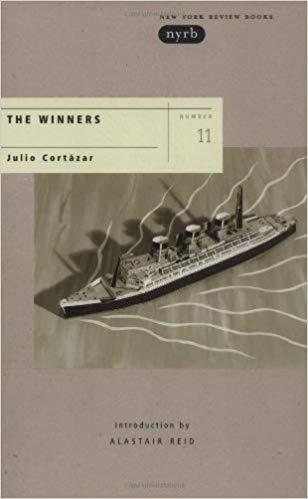

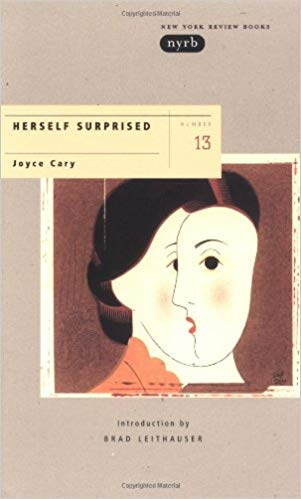

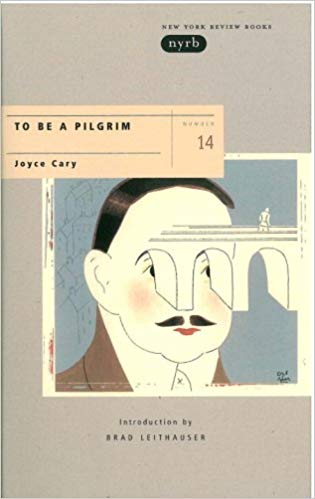

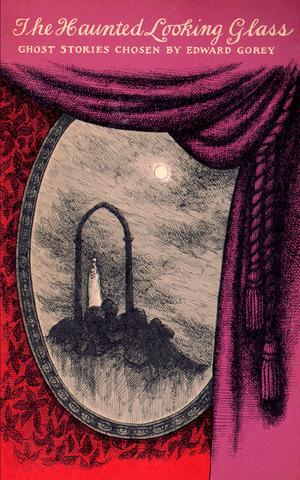

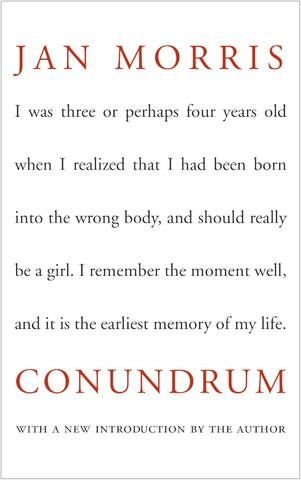

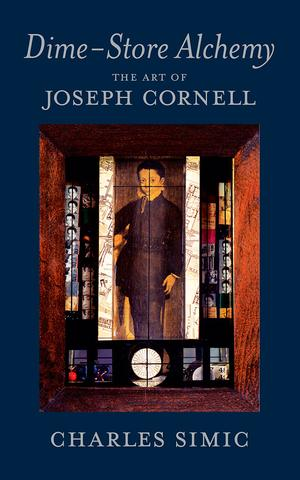

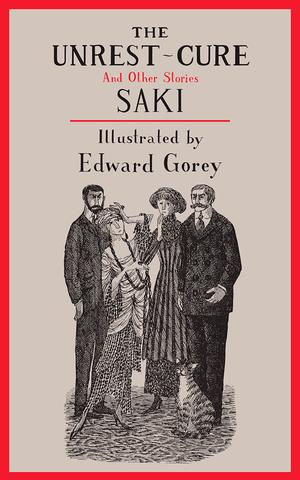

In [34]:
for img in list(books_df[pd.isnull(books_df.spine_color)].cover_path):
    display(Image(img, width=200))           

Verify some of the other fields.

In [35]:
assert len(books_df[pd.isnull(books_df.title)]) == 0

In [36]:
assert len(books_df[pd.isnull(books_df.date_published)]) == 0

In [37]:
assert len(books_df[pd.isnull(books_df.author)]) == 0

### Analyze colors

Spine colors

In [38]:
books_df.spine_color.value_counts().head(10).reset_index()

,index,spine_color
0,#FF0000,13
1,#20181B,11
2,#000000,6
3,#C00000,4
4,#FFFFFF,3
5,#D00000,2
6,#E70000,2
7,#76E4D7,2
8,#770000,2
9,#A20000,2


Here they are

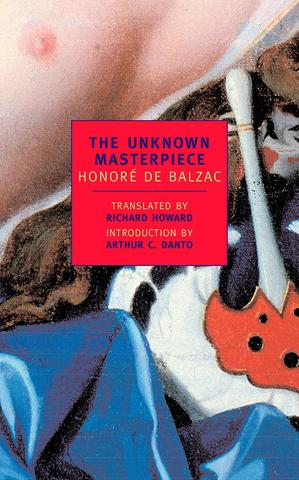

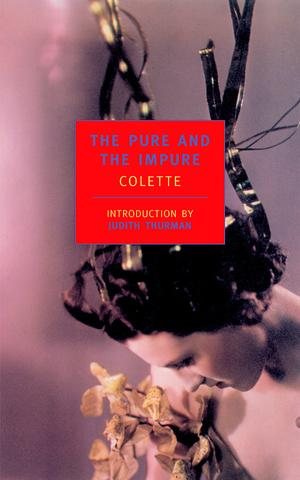

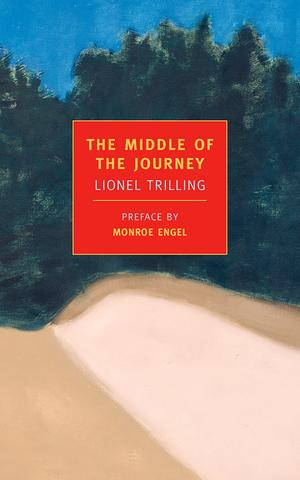

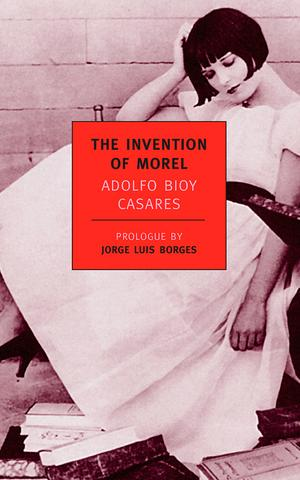

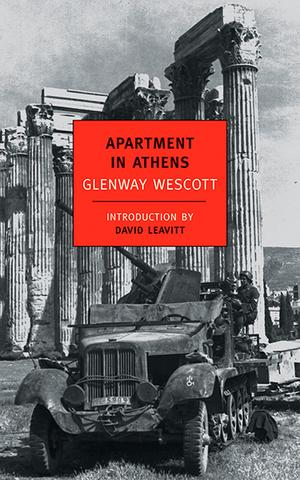

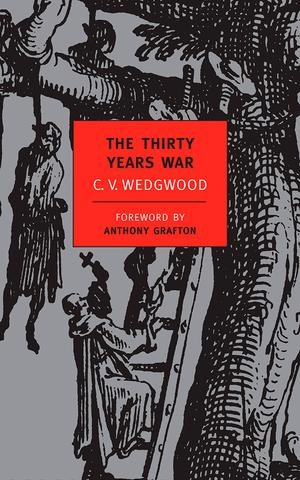

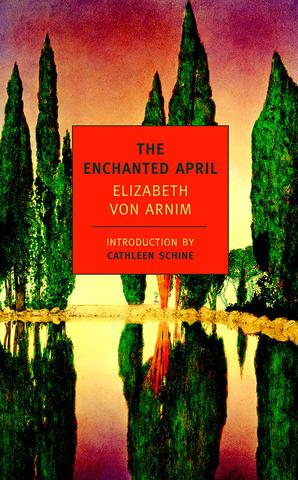

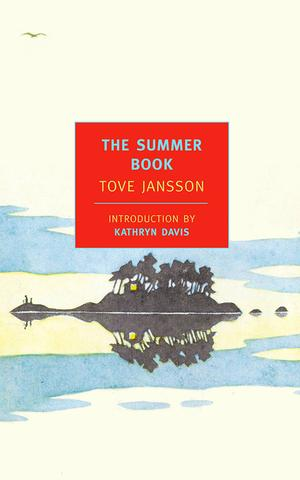

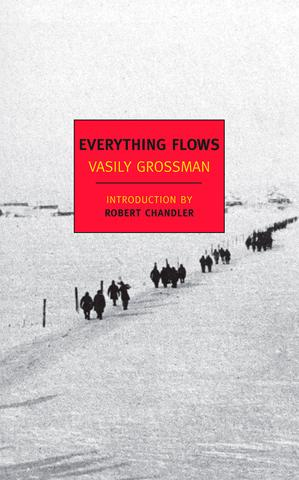

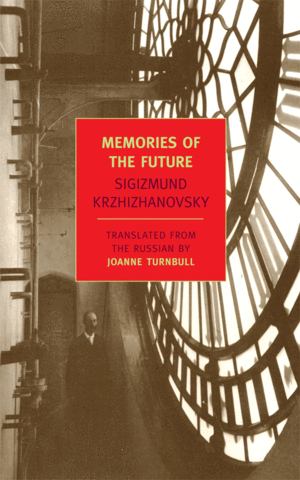

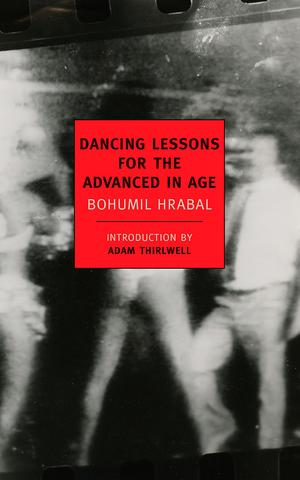

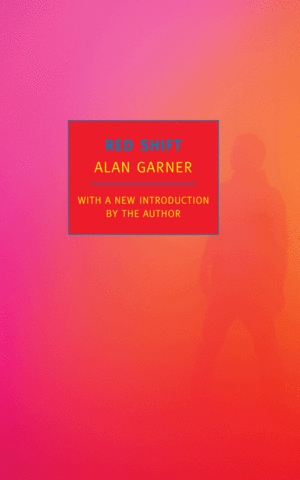

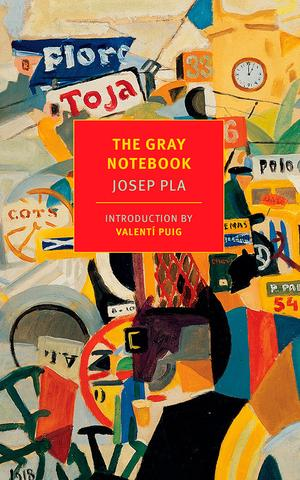

In [39]:
for img in list(books_df[books_df.spine_color == "#FF0000"].cover_path):
    display(Image(img, width=200))           

The spine colors were grouped using the colorjs project's color-name service for aggregation.

In [40]:
books_df.spine_color_group.value_counts().head(10).reset_index()

,index,spine_color_group
0,brown,91
1,black,79
2,red,65
3,indigo,31
4,gold,30
5,gray,30
6,teal,25
7,white,24
8,purple,23
9,orange,22


As with the spine colors, seven books should not have a value.

In [41]:
assert len(books_df[pd.isnull(books_df.spine_color_group)]) == 7

### Cover art analysis

We used [ImageMagick](https://www.imagemagick.org/script/index.php) to process each cover and find its dominant color. ImageMagick can, among many other things, record the color of every pixel in an image and tally each color at the end. We used this feature to find the color that showed up most frequently, which we declared the dominant color of the image.

But before we can do any of that we need to standardize the size of the covers.

In [42]:
%%capture
!sh resize.sh

Next we "quantize" each cover to reduce their unique colors by combining similar shades. This is a common technique in color analysis to eliminate noise.

In [43]:
%%capture
!sh quantize.sh

Now the quantized covers are analyzed to determine each's dominate color using ImageMagick's "histogram" method.

In [44]:
%%capture
!sh analyze.sh

Merge the result of that analysis with the canonical books list.

In [45]:
covercolors_df = pd.read_csv("data/analyzed-covers.csv") 

In [46]:
final_df = books_df.merge(covercolors_df, on="slug", how="left")

Verify the row counts one last time.

In [47]:
assert len(final_df) == len(books_df)

In [48]:
assert len(final_df[pd.isnull(final_df.dominant_cover_color)]) == 0

### Analyze languages

Some languages could not be parsed. They will be manually corrected.

In [49]:
language_corrections = dict(
    (r['slug'], r['original_language']) for r in
        csv.DictReader(open("./data/language-corrections.csv", 'r'))
)

In [50]:
final_df['original_language'] = final_df.apply(lambda x: language_corrections.get(x.slug, x.original_language), axis=1)

Verify that all books have an original language

In [51]:
assert len(final_df[pd.isnull(final_df.original_language)]) == 0

In [52]:
final_df.original_language.value_counts().reset_index().original_language.sum()

500

In [63]:
final_df.original_language.value_counts().reset_index().head(10)

,index,original_language
0,English,265
1,French,71
2,German,41
3,Russian,28
4,Italian,26
5,Spanish,11
6,Hungarian,10
7,Chinese,8
8,Swedish,5
9,Japanese,4


### Analyze authors

Separate authors from introductions and afterwards and translators and the like.

In [54]:
def parse_author(s):
    s = s.split(",")[0]
    s = s.split(";")[0]
    s = s.split(":")[0]
    return s.strip()

In [55]:
final_df['parsed_author'] = final_df.author.apply(parse_author)

A few must be manually corrected

In [56]:
author_corrections = {
    '9781590171783': 'Eileen Chang',
    '9781681370224': '',
    '9781681370309': ''
}

In [57]:
final_df['parsed_author'] = final_df.apply(lambda x: author_corrections.get(x.isbn, x.parsed_author), axis=1)

Now the analysis

In [64]:
final_df.parsed_author.value_counts().reset_index().head(3)

,index,parsed_author
0,Georges Simenon,11
1,Kingsley Amis,9
2,Patrick Leigh Fermor,8


Output Simenon covers

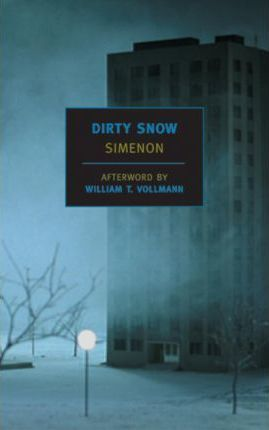

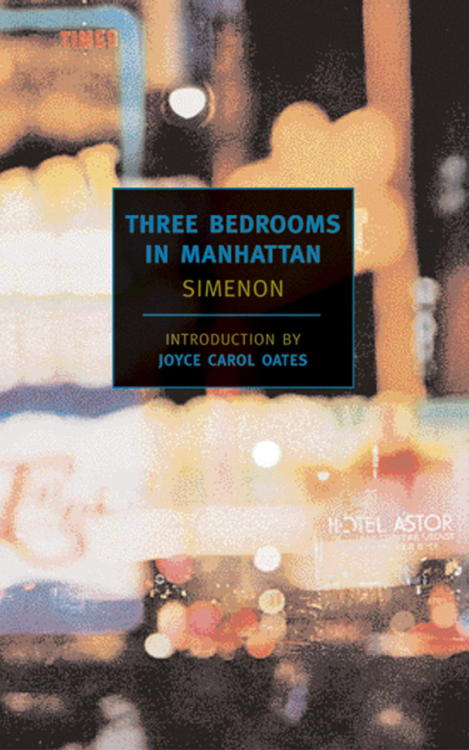

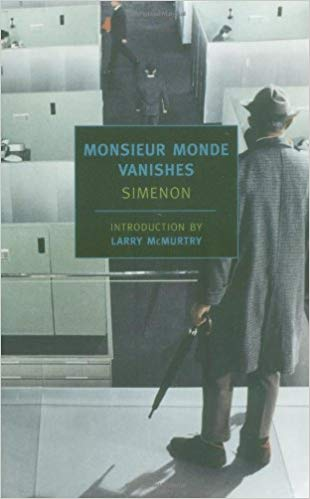

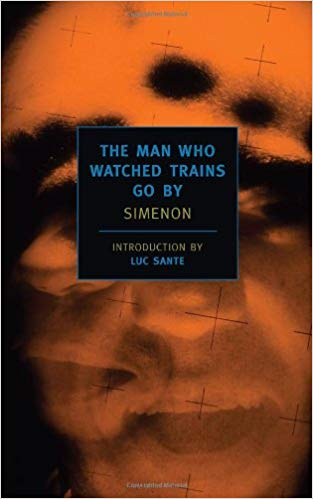

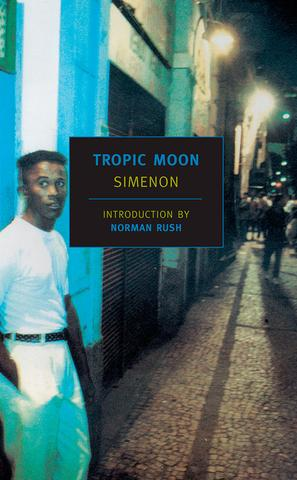

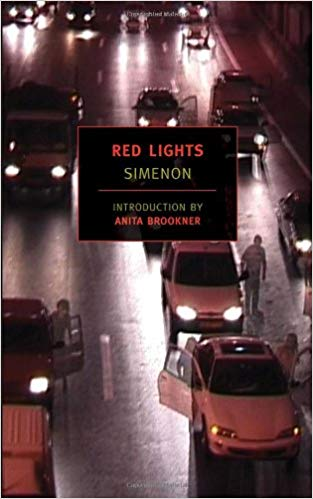

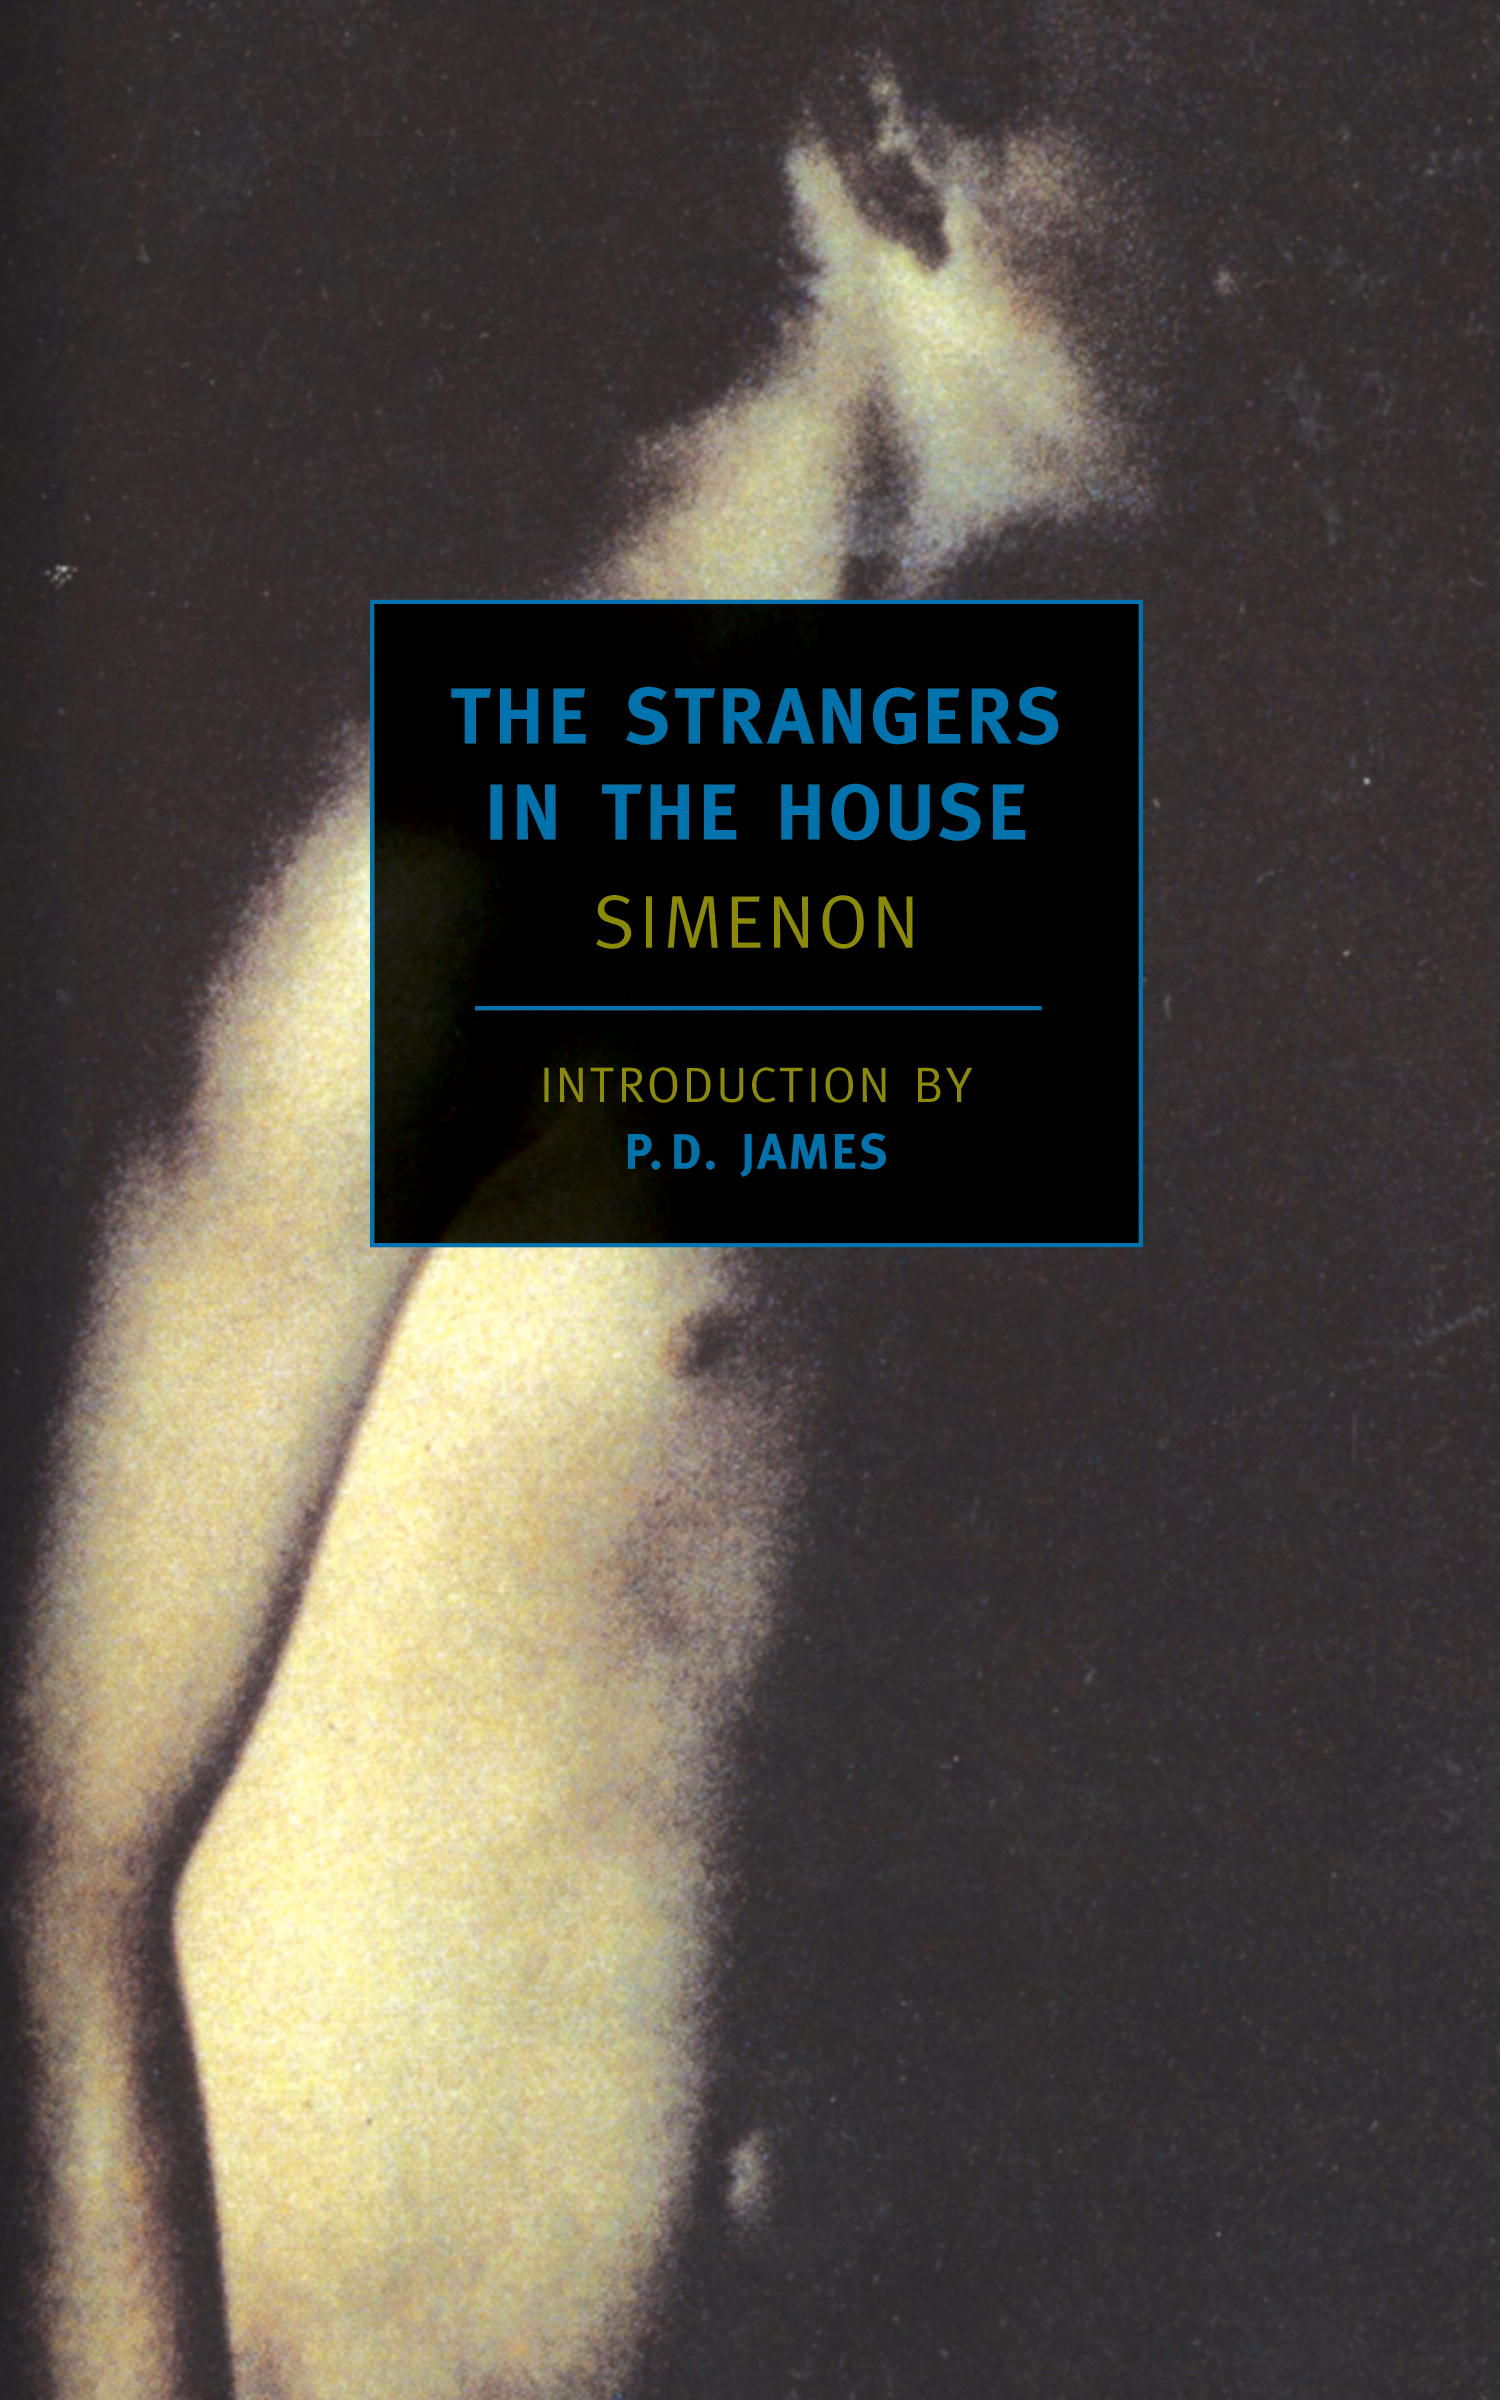

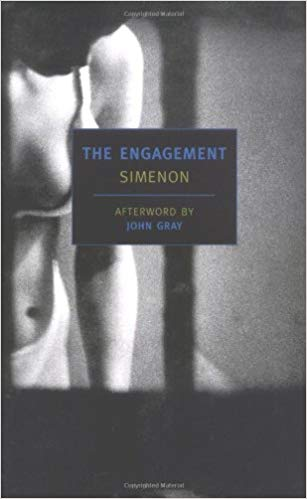

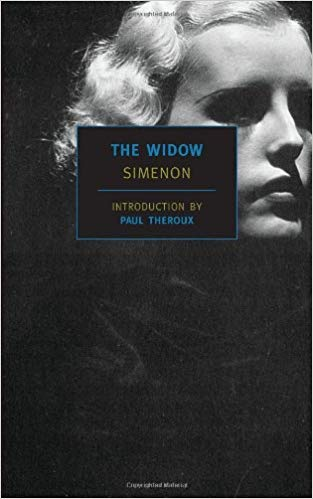

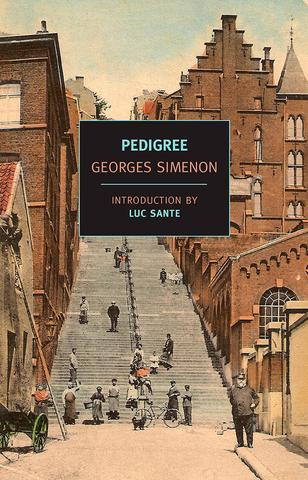

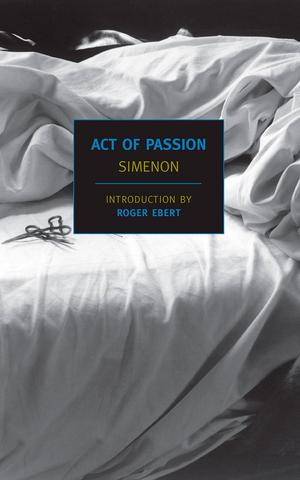

In [59]:
for img in list(final_df[final_df.parsed_author == "Georges Simenon"].cover_path):
    display(Image(img, width=200))

Output Amis covers

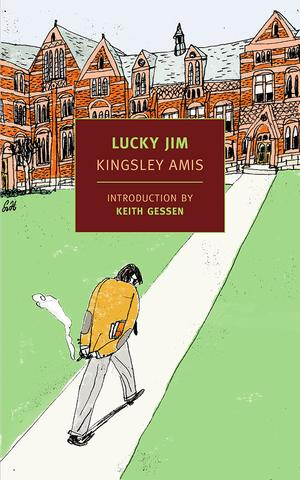

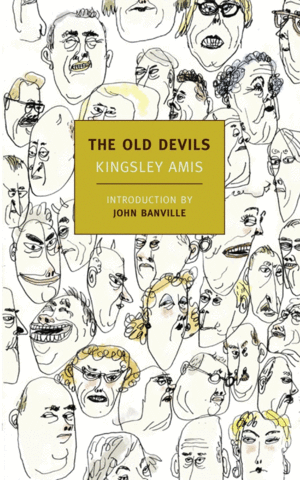

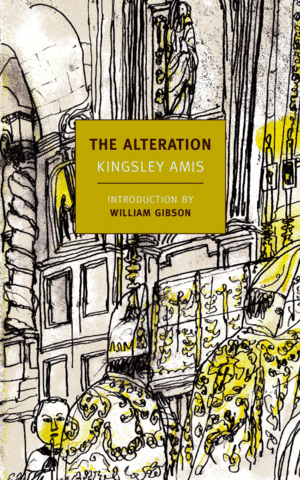

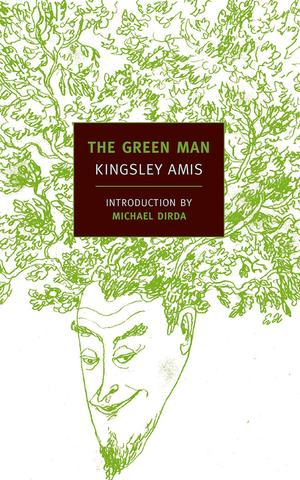

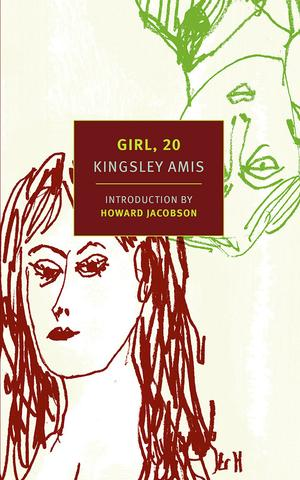

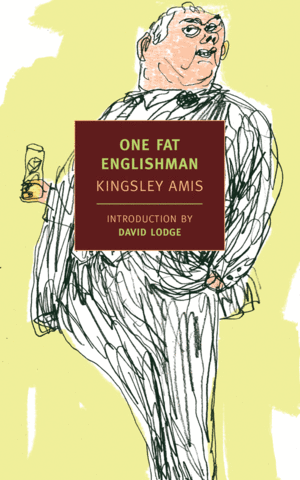

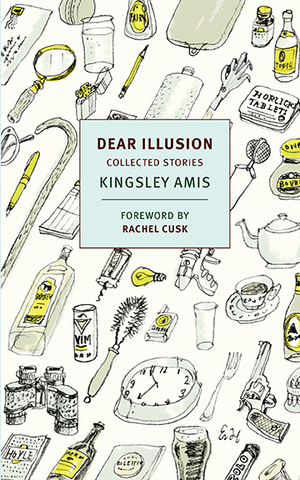

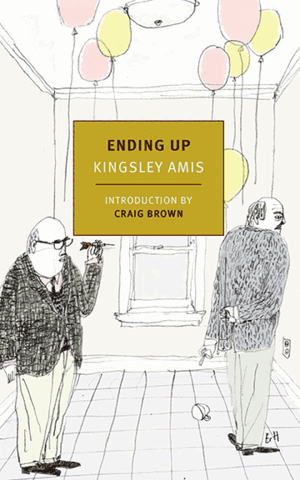

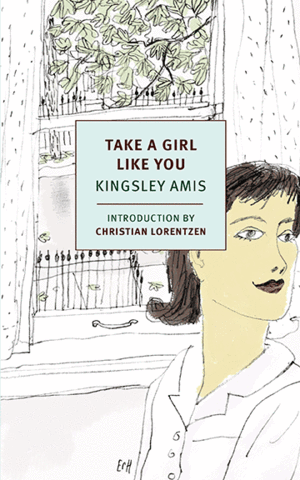

In [60]:
for img in list(final_df[final_df.parsed_author == "Kingsley Amis"].cover_path):
    display(Image(img, width=200))

### Write out the final file

In [67]:
final_df['date_published'] = pd.to_datetime(final_df.date_published)

In [68]:
trimmed_df = final_df[[
    'isbn',
    'title',
    'parsed_author',
    'date_published',
    'year',
    'spine_color',
    'spine_color_group',
    'dominant_cover_color'
]].sort_values(["date_published", "title"])

In [69]:
final_df.to_csv("./data/books.csv", index=False)

In [70]:
trimmed_df.to_csv("./data/graphic.csv", index=False)